## Setup: Import Libraries and Database Connection

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine, text

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


In [12]:
# Database connection
db_url = "postgresql://postgres:aa@localhost:5432/olap"
engine = create_engine(db_url)

print("Database connection established!")

Database connection established!


---
## Task 12: Dashboard - Sales by Category and Year

This dashboard provides multiple views of sales data:
1. Total sales by category (bar chart)
2. Sales trends over time by category (line chart)
3. Year-over-year comparison (grouped bar chart)
4. Category contribution percentage (pie chart)

In [13]:
# Query: Sales by Category and Year
query_dashboard = text("""
SELECT 
    p.category,
    t.year,
    ROUND(SUM(f.sales)::numeric, 2) as total_sales,
    COUNT(*) as transaction_count
FROM fact_sales f
JOIN dim_product p ON f.product_key = p.product_key
JOIN dim_time t ON f.time_key = t.time_key
GROUP BY p.category, t.year
ORDER BY t.year, p.category
""")

df_dashboard = pd.read_sql(query_dashboard, engine)
print(f"Retrieved {len(df_dashboard)} records")
df_dashboard.head(10)

Retrieved 12 records


,category,year,total_sales,transaction_count
0,Furniture,2015,156477.92,414
1,Office Supplies,2015,149512.81,1192
2,Technology,2015,173865.54,347
3,Furniture,2016,164053.88,440
4,Office Supplies,2016,133124.36,1210
5,Technology,2016,162257.70,405
6,Furniture,2017,195813.15,547
7,Office Supplies,2017,182417.65,1537
8,Technology,2017,221962.00,450
9,Furniture,2018,212313.80,677


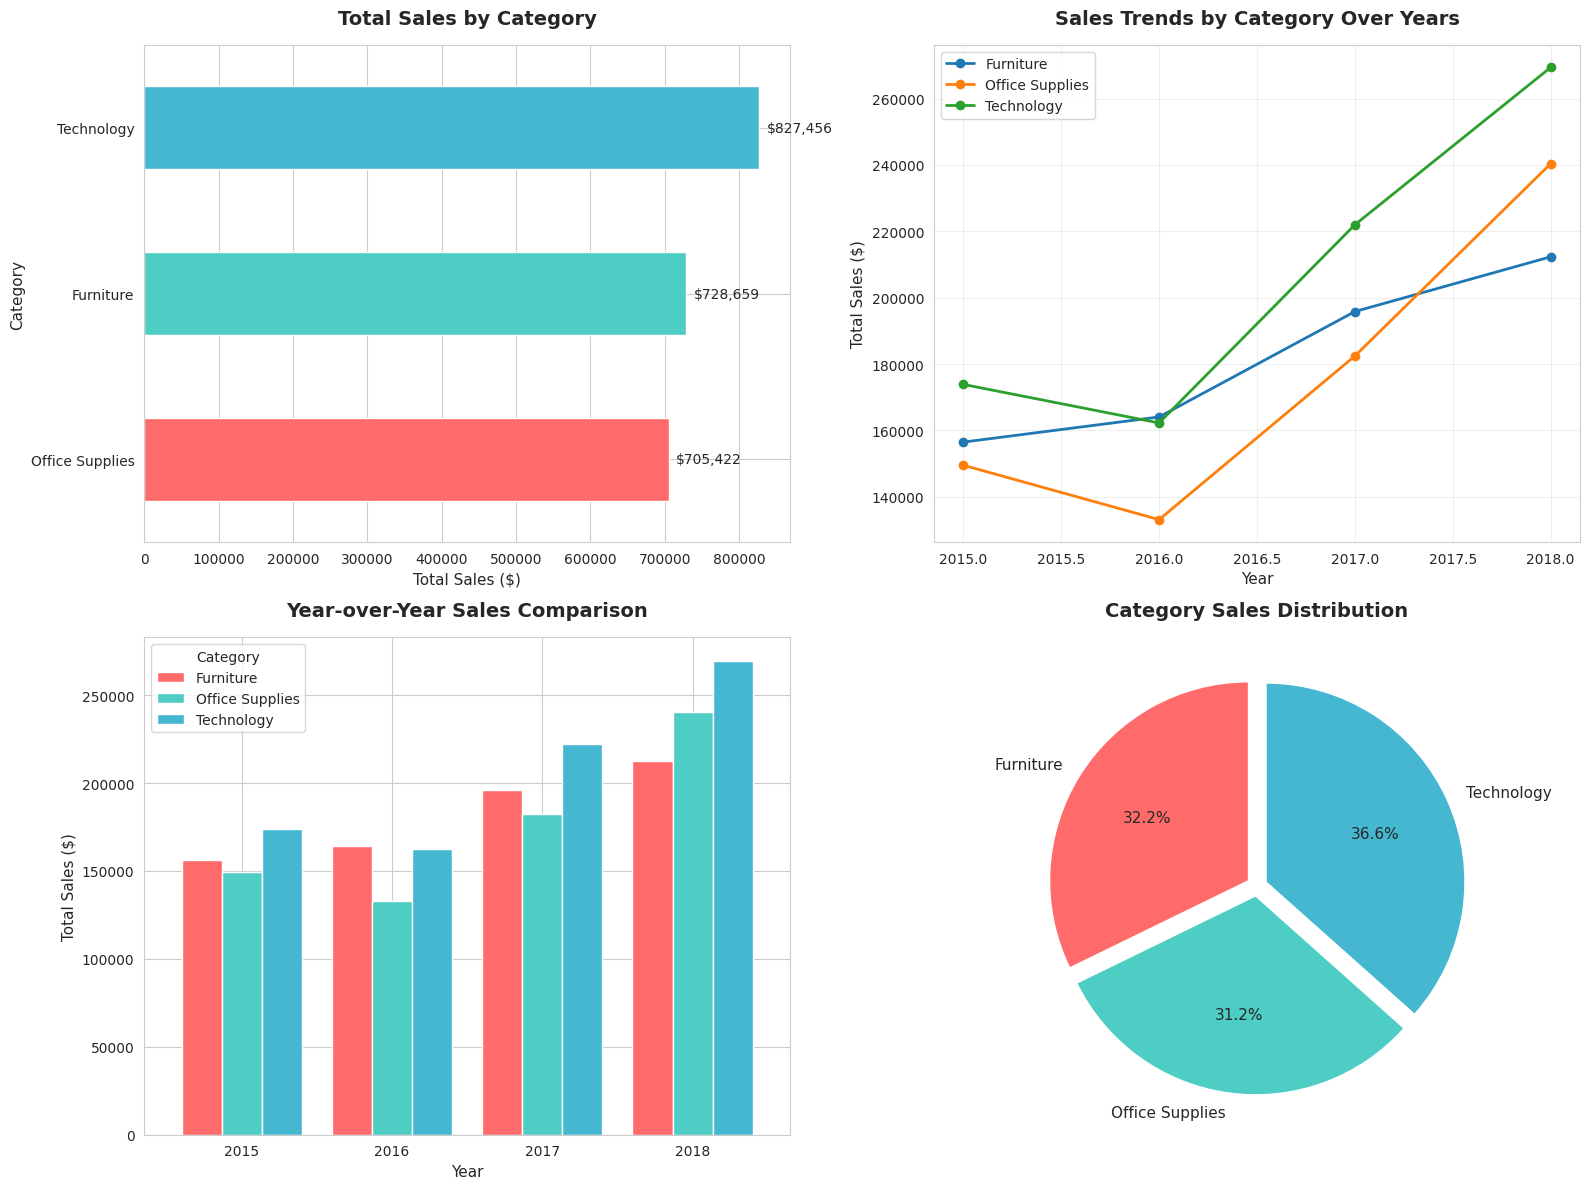


📊 Dashboard Summary:
Total Sales: $2,261,536.97
Categories: 3
Years Covered: 2015 - 2018


In [14]:
# Create comprehensive dashboard with 4 subplots
fig = plt.figure(figsize=(16, 12))

# 1. Total Sales by Category (Bar Chart)
ax1 = plt.subplot(2, 2, 1)
category_totals = df_dashboard.groupby('category')['total_sales'].sum().sort_values(ascending=True)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
category_totals.plot(kind='barh', ax=ax1, color=colors)
ax1.set_title('Total Sales by Category', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Total Sales ($)', fontsize=11)
ax1.set_ylabel('Category', fontsize=11)
for i, v in enumerate(category_totals):
    ax1.text(v + 10000, i, f'${v:,.0f}', va='center', fontsize=10)

# 2. Sales Trends Over Time (Line Chart)
ax2 = plt.subplot(2, 2, 2)
for category in df_dashboard['category'].unique():
    cat_data = df_dashboard[df_dashboard['category'] == category]
    ax2.plot(cat_data['year'], cat_data['total_sales'], marker='o', linewidth=2, label=category)
ax2.set_title('Sales Trends by Category Over Years', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('Year', fontsize=11)
ax2.set_ylabel('Total Sales ($)', fontsize=11)
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Year-over-Year Comparison (Grouped Bar Chart)
ax3 = plt.subplot(2, 2, 3)
pivot_data = df_dashboard.pivot(index='year', columns='category', values='total_sales')
pivot_data.plot(kind='bar', ax=ax3, color=colors, width=0.8)
ax3.set_title('Year-over-Year Sales Comparison', fontsize=14, fontweight='bold', pad=15)
ax3.set_xlabel('Year', fontsize=11)
ax3.set_ylabel('Total Sales ($)', fontsize=11)
ax3.legend(title='Category', fontsize=10)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)

# 4. Category Contribution (Pie Chart)
ax4 = plt.subplot(2, 2, 4)
category_totals_pie = df_dashboard.groupby('category')['total_sales'].sum()
explode = (0.05, 0.05, 0.05)
ax4.pie(category_totals_pie, labels=category_totals_pie.index, autopct='%1.1f%%',
        startangle=90, colors=colors, explode=explode, textprops={'fontsize': 11})
ax4.set_title('Category Sales Distribution', fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

print("\n📊 Dashboard Summary:")
print(f"Total Sales: ${df_dashboard['total_sales'].sum():,.2f}")
print(f"Categories: {df_dashboard['category'].nunique()}")
print(f"Years Covered: {df_dashboard['year'].min()} - {df_dashboard['year'].max()}")

---
## Task 13: RANK vs DENSE_RANK Comparison

This visualization demonstrates the difference between RANK and DENSE_RANK:
- **RANK**: Skips ranks after ties (e.g., 1, 2, 2, 4)
- **DENSE_RANK**: No gaps in ranking (e.g., 1, 2, 2, 3)

In [15]:
# Query: Top Products with RANK and DENSE_RANK
query_rank = text("""
SELECT 
    p.product_name,
    ROUND(SUM(f.sales)::numeric, 2) as total_sales,
    RANK() OVER (ORDER BY SUM(f.sales) DESC) as rank_value,
    DENSE_RANK() OVER (ORDER BY SUM(f.sales) DESC) as dense_rank_value
FROM fact_sales f
JOIN dim_product p ON f.product_key = p.product_key
GROUP BY p.product_name
ORDER BY total_sales DESC
LIMIT 15
""")

df_rank = pd.read_sql(query_rank, engine)
print(f"Retrieved top {len(df_rank)} products")
df_rank

Retrieved top 15 products


,product_name,total_sales,rank_value,dense_rank_value
0,Canon imageCLASS 2200 Advanced Copier,61599.83,1,1
1,Fellowes PB500 Electric Punch Plastic Comb Bin...,27453.38,2,2
2,Cisco TelePresence System EX90 Videoconferenci...,22638.48,3,3
3,HON 5400 Series Task Chairs for Big and Tall,21870.57,4,4
4,GBC DocuBind TL300 Electric Binding System,19823.48,5,5
5,GBC Ibimaster 500 Manual ProClick Binding System,19024.50,6,6
6,Hewlett Packard LaserJet 3310 Copier,18839.68,7,7
7,HP Designjet T520 Inkjet Large Format Printer ...,18374.90,8,8
8,GBC DocuBind P400 Electric Binding System,17965.07,9,9
9,High Speed Automatic Electric Letter Opener,17030.31,10,10


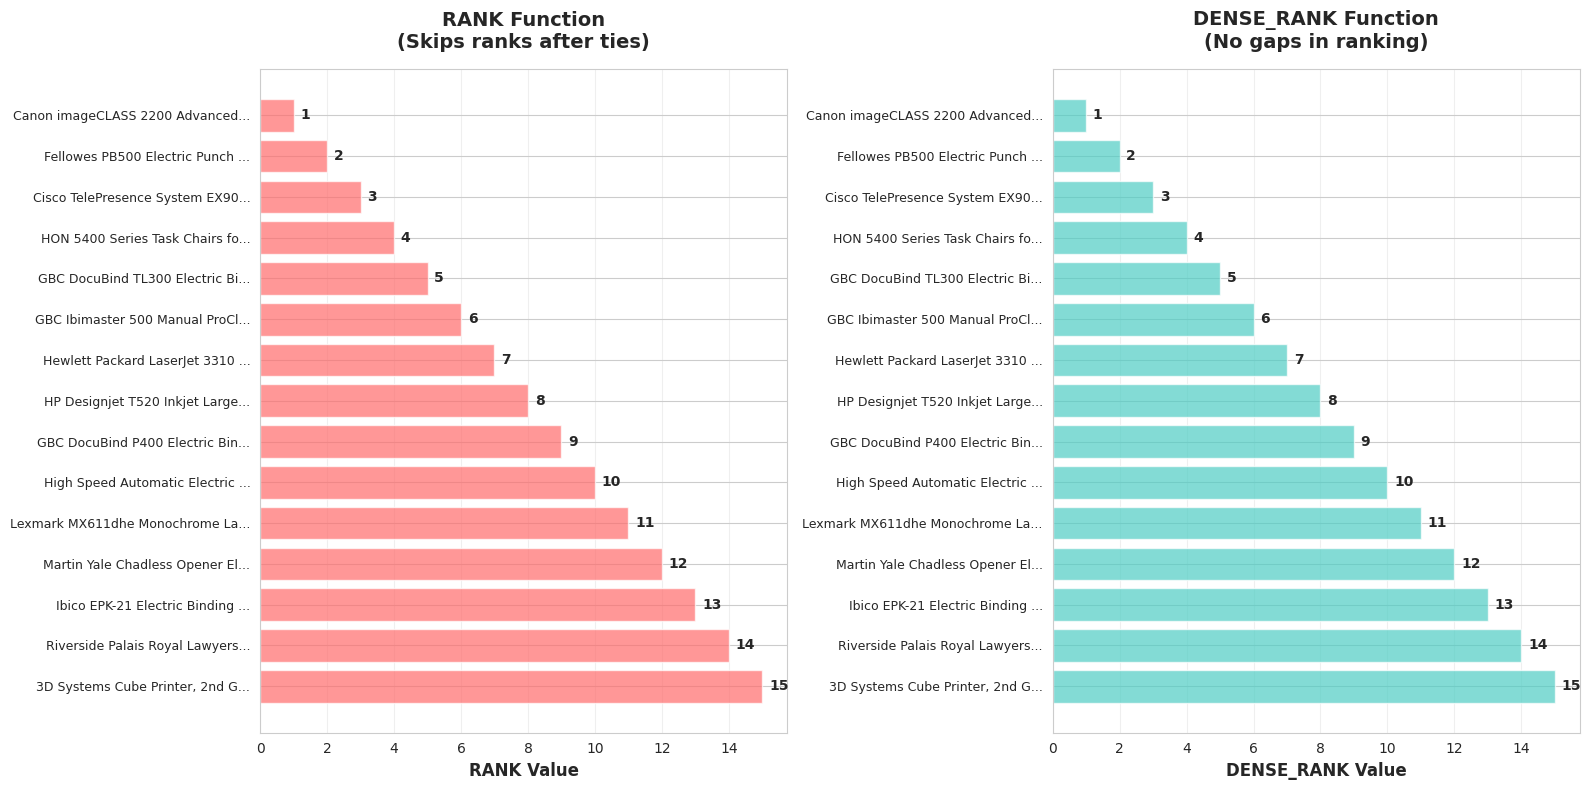


🔍 Key Differences:
No ties detected in top 15 products - both rankings are identical


In [16]:
# Create comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Shorten product names for better display
df_rank['short_name'] = df_rank['product_name'].str[:30] + '...'

# Left plot: RANK
ax1.barh(range(len(df_rank)), df_rank['rank_value'], color='#FF6B6B', alpha=0.7)
ax1.set_yticks(range(len(df_rank)))
ax1.set_yticklabels(df_rank['short_name'], fontsize=9)
ax1.set_xlabel('RANK Value', fontsize=12, fontweight='bold')
ax1.set_title('RANK Function\n(Skips ranks after ties)', fontsize=14, fontweight='bold', pad=15)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Add rank values on bars
for i, v in enumerate(df_rank['rank_value']):
    ax1.text(v + 0.2, i, str(int(v)), va='center', fontsize=10, fontweight='bold')

# Right plot: DENSE_RANK
ax2.barh(range(len(df_rank)), df_rank['dense_rank_value'], color='#4ECDC4', alpha=0.7)
ax2.set_yticks(range(len(df_rank)))
ax2.set_yticklabels(df_rank['short_name'], fontsize=9)
ax2.set_xlabel('DENSE_RANK Value', fontsize=12, fontweight='bold')
ax2.set_title('DENSE_RANK Function\n(No gaps in ranking)', fontsize=14, fontweight='bold', pad=15)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# Add dense_rank values on bars
for i, v in enumerate(df_rank['dense_rank_value']):
    ax2.text(v + 0.2, i, str(int(v)), va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Show the difference
print("\n🔍 Key Differences:")
df_rank['rank_diff'] = df_rank['rank_value'] - df_rank['dense_rank_value']
has_gaps = df_rank[df_rank['rank_diff'] > 0]
if len(has_gaps) > 0:
    print(f"\nProducts where RANK and DENSE_RANK differ:")
    print(has_gaps[['product_name', 'rank_value', 'dense_rank_value', 'rank_diff']])
else:
    print("No ties detected in top 15 products - both rankings are identical")

---
## Task 14: Heatmap - Sales by Region and Quarter

This heatmap visualizes sales performance across different regions and quarters, making it easy to identify:
- High-performing regions and seasons
- Low-performing regions and seasons
- Seasonal patterns

In [17]:
# Query: Sales by Region and Quarter
query_heatmap = text("""
SELECT 
    g.region,
    'Q' || t.quarter::text as quarter,
    ROUND(SUM(f.sales)::numeric, 2) as total_sales
FROM fact_sales f
JOIN dim_geography g ON f.geo_key = g.geo_key
JOIN dim_time t ON f.time_key = t.time_key
GROUP BY g.region, t.quarter
ORDER BY g.region, t.quarter
""")

df_heatmap = pd.read_sql(query_heatmap, engine)
print(f"Retrieved {len(df_heatmap)} region-quarter combinations")
df_heatmap

Retrieved 16 region-quarter combinations


,region,quarter,total_sales
0,Central,Q1,79610.02
1,Central,Q2,90144.06
2,Central,Q3,133175.87
3,Central,Q4,189716.95
4,East,Q1,63406.32
5,East,Q2,125099.98
6,East,Q3,185777.32
7,East,Q4,295235.23
8,South,Q1,98257.33
9,South,Q2,85172.23


In [18]:
# Create pivot table for heatmap
pivot_heatmap = df_heatmap.pivot(index='region', columns='quarter', values='total_sales')

# Ensure quarters are in correct order
quarter_order = ['Q1', 'Q2', 'Q3', 'Q4']
pivot_heatmap = pivot_heatmap.reindex(columns=[q for q in quarter_order if q in pivot_heatmap.columns])

print("\nPivot Table (Sales by Region and Quarter):")
print(pivot_heatmap)


Pivot Table (Sales by Region and Quarter):
quarter         Q1         Q2         Q3         Q4
region                                             
Central   79610.02   90144.06  133175.87  189716.95
East      63406.32  125099.98  185777.32  295235.23
South     98257.33   85172.23   82202.77  123519.12
West     109962.71  135791.06  201799.01  262666.99


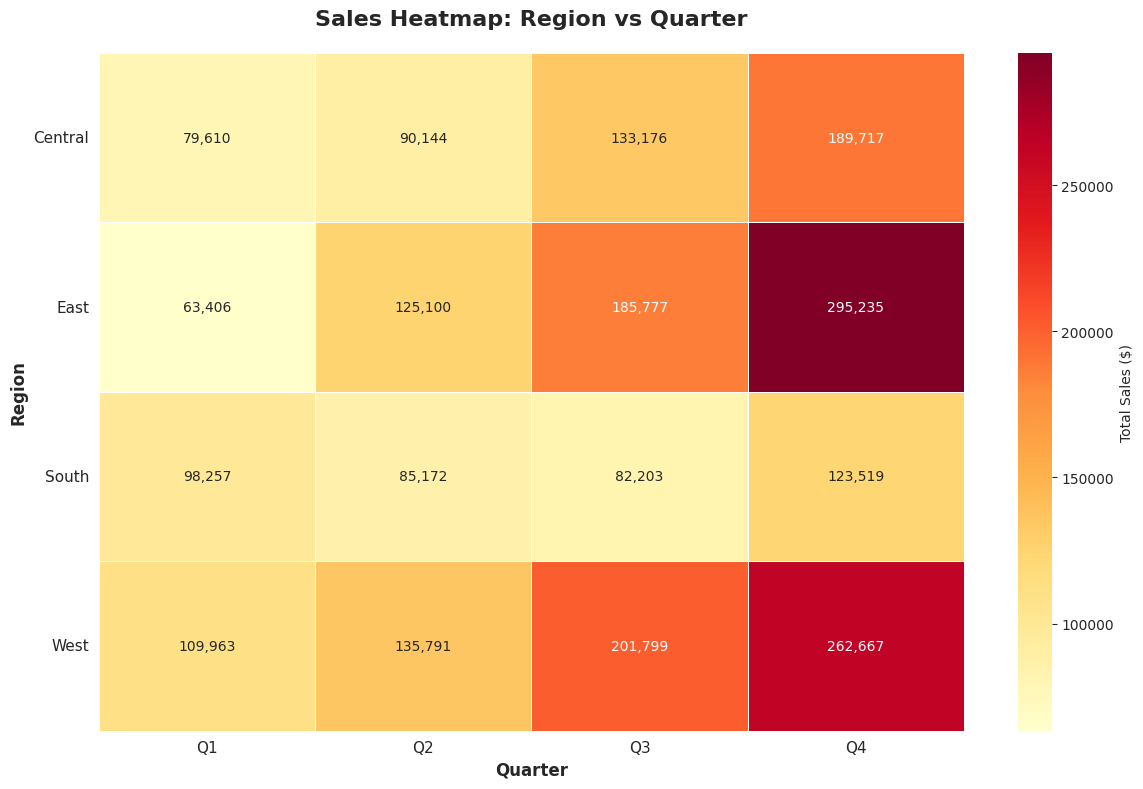


📈 Heatmap Insights:

Highest Sales: $295,235.23
  → East in Q4

Lowest Sales: $63,406.32
  → East in Q1

Average Sales by Region:
  Central: $123,161.73
  East: $167,379.71
  South: $97,287.86
  West: $177,554.94

Average Sales by Quarter:
  Q1: $87,809.10
  Q2: $109,051.83
  Q3: $150,738.74
  Q4: $217,784.57


In [19]:
# Create heatmap visualization
plt.figure(figsize=(12, 8))

# Create heatmap with annotations
ax = sns.heatmap(pivot_heatmap, 
                 annot=True, 
                 fmt=',.0f',
                 cmap='YlOrRd',
                 cbar_kws={'label': 'Total Sales ($)'},
                 linewidths=0.5,
                 linecolor='white',
                 square=False,
                 vmin=pivot_heatmap.min().min(),
                 vmax=pivot_heatmap.max().max())

plt.title('Sales Heatmap: Region vs Quarter', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Quarter', fontsize=12, fontweight='bold')
plt.ylabel('Region', fontsize=12, fontweight='bold')
plt.xticks(rotation=0, fontsize=11)
plt.yticks(rotation=0, fontsize=11)

# Adjust colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

# Statistical insights
print("\n📈 Heatmap Insights:")
print(f"\nHighest Sales: ${pivot_heatmap.max().max():,.2f}")
max_loc = pivot_heatmap.stack().idxmax()
print(f"  → {max_loc[0]} in {max_loc[1]}")

print(f"\nLowest Sales: ${pivot_heatmap.min().min():,.2f}")
min_loc = pivot_heatmap.stack().idxmin()
print(f"  → {min_loc[0]} in {min_loc[1]}")

print("\nAverage Sales by Region:")
for region in pivot_heatmap.index:
    avg_sales = pivot_heatmap.loc[region].mean()
    print(f"  {region}: ${avg_sales:,.2f}")

print("\nAverage Sales by Quarter:")
for quarter in pivot_heatmap.columns:
    avg_sales = pivot_heatmap[quarter].mean()
    print(f"  {quarter}: ${avg_sales:,.2f}")

---
## Summary

### Part 3 Visualizations Complete ✅

1. **Task 12 - Dashboard**: 4-panel comprehensive view of sales by category and year
   - Total sales by category (bar chart)
   - Sales trends over time (line chart)
   - Year-over-year comparison (grouped bar chart)
   - Category distribution (pie chart)

2. **Task 13 - RANK Comparison**: Side-by-side visualization showing differences between RANK and DENSE_RANK functions

3. **Task 14 - Heatmap**: Sales performance by region and quarter with color-coded intensity and statistical insights

In [20]:
# Close database connection
engine.dispose()
print("Database connection closed.")

Database connection closed.
